# Session 5 - Advanced Data Visualization
## Cohort Visualization

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from operator import attrgetter

## 1. Import Data

In [2]:
df = pd.read_csv("session_5_cohort_analysis.csv",
                       dtype={"CustomerID": str,
                              "InvoiceID": str},
                       parse_dates=["InvoiceDate"],)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-04-01 10:00:00,1.95,13313,United Kingdom
1,539993,21499,BLUE POLKADOT WRAP,25,2011-04-01 10:00:00,0.42,13313,United Kingdom
2,539993,21498,RED RETROSPOT WRAP,25,2011-04-01 10:00:00,0.42,13313,United Kingdom
3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-04-01 10:00:00,2.10,13313,United Kingdom
4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-04-01 10:00:00,1.25,13313,United Kingdom


## 2. Cohort Analysis : Data Preprocessing

In order to make a proper data for retention cohort visualization, you must transform the raw data into a new data frame which consist of these 4 columns:
> Cohort Date | Current Activity Date | Total Distinct Subject | Period Distance (Cohort Date - Current Activity Date)

1. **Cohort Date**: The date of the first activity time started for each individual (i.e. First Transaction Date, First Open Application Date, ...)
2. **Current Activity Date**: The activity recurrence time for each individual (i.e. Second Transaction Date, Third Open Application Date, ...)
3. **Total Distinct Subject**: Total of distinct actors of measured activity grouped by Cohort Date and Current Activity Date (i.e. Total New Customer, Total New User, ...)
4. **Period Distance**: Is the distance between Cohort Date and Current Activity Date, lowest is 0, and always positive number.

For example:

| cohort_month | current_transaction_month | total_users | period_distance |
| -- | -- |-- | -- |
| 2021-01 | 2021-01 | 500 | 0 |
| 2021-01 | 2021-02 | 400 | 1 | 
| ....  | ... | ... | ... |
| 2021-01 | 2021-12 | 30  | 11|


**Interpretation**:

1. There are 500 users who made first transaction in 2021-01 and made their transaction again in the same month (2021-01)
2. There are 400 users who made first transaction in 2021-01 and made their transaction again in 2021-02 
3. ...
4. There are 30 users who made first transaction in 2021-01 and made their transaction again in 2021-12

**Base Cohort Table Steps**:
1. Cohort Date: Find out the first acticity date of each user (i.e. first transaction month, first open apps date, ...)
2. Current Activity Date: Find out the current activity date of each user (i.e. current transaction date, ...)
3. Aggregate Distinct Total Users by Cohort Date and Current Activity Date  (i.e. Count Distinct CustomerID)
4. Create Period column by substracting Cohort Date and Current Activity Date
5. Make a pivot table, which indexed by Cohort Date, Columns = Period, and value = Total Distinct Users

### *In this case, we want to create monthly cohort, so we will transform date into monthly format

In [3]:
# Step 1 and Step 2:
# First of all, we create cohort date as cohort month, by finding the minimum date of invoice of each users
# Then we transform the format into monthly-based
df["cohort_month"] = df.groupby("CustomerID")["InvoiceDate"].transform("min").dt.to_period("M")

# We create current activity date: current order month, just transform invoicedate into monthly format
df["current_order_month"] = df["InvoiceDate"].dt.to_period("M")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cohort_month,current_order_month
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-04-01 10:00:00,1.95,13313,United Kingdom,2011-04,2011-04
1,539993,21499,BLUE POLKADOT WRAP,25,2011-04-01 10:00:00,0.42,13313,United Kingdom,2011-04,2011-04
2,539993,21498,RED RETROSPOT WRAP,25,2011-04-01 10:00:00,0.42,13313,United Kingdom,2011-04,2011-04
3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-04-01 10:00:00,2.10,13313,United Kingdom,2011-04,2011-04
4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-04-01 10:00:00,1.25,13313,United Kingdom,2011-04,2011-04


In [4]:
# Step 3:
# To find out total distinct users, lets make an aggregation based on cohort_month and current order month
df_cohort = df.groupby(["cohort_month", "current_order_month"]) \
                    .agg(n_customers=("CustomerID", "nunique")) \
                    .reset_index(drop=False)
df_cohort.head()

,cohort_month,current_order_month,n_customers
0,2011-01,2011-01,967
1,2011-01,2011-02,320
2,2011-01,2011-03,368
3,2011-01,2011-04,338
4,2011-01,2011-05,381


In [5]:
# Step 4:
# Next, we will subtracting the cohort month vs current order month to get the month distance
df_cohort["period_number"] = (df_cohort.current_order_month - df_cohort.cohort_month).apply(attrgetter('n'))
df_cohort.head()

,cohort_month,current_order_month,n_customers,period_number
0,2011-01,2011-01,967,0
1,2011-01,2011-02,320,1
2,2011-01,2011-03,368,2
3,2011-01,2011-04,338,3
4,2011-01,2011-05,381,4


In [6]:
# Step 5. Create pivot table: index = cohort month, columns = period, value = total users
cohort_retention_pivot = df_cohort.pivot_table(index="cohort_month",
                                     columns = "period_number",
                                     values="n_customers")
cohort_retention_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2011-01,967.0,320.0,368.0,338.0,381.0,397.0,396.0,341.0,417.0,413.0,481.0,191.0
2011-02,542.0,137.0,142.0,166.0,166.0,173.0,162.0,169.0,172.0,202.0,59.0,NaN
2011-03,500.0,109.0,121.0,123.0,129.0,113.0,120.0,137.0,144.0,35.0,NaN,NaN
2011-04,383.0,86.0,84.0,82.0,75.0,76.0,106.0,98.0,24.0,NaN,NaN,NaN
2011-05,309.0,61.0,64.0,54.0,77.0,58.0,88.0,23.0,NaN,NaN,NaN,NaN
2011-06,314.0,57.0,55.0,64.0,61.0,87.0,21.0,NaN,NaN,NaN,NaN,NaN
2011-07,252.0,50.0,47.0,53.0,66.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,186.0,32.0,44.0,52.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09,255.0,40.0,55.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# We can also transform the number into percentages:
cohort_size = cohort_retention_pivot.iloc[:,0]
retention_in_percentage = cohort_retention_pivot.divide(cohort_size, axis = 0)
retention_in_percentage

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2011-01,1.0,0.330920,0.380558,0.349535,0.394002,0.410548,0.409514,0.352637,0.431231,0.427094,0.497415,0.197518
2011-02,1.0,0.252768,0.261993,0.306273,0.306273,0.319188,0.298893,0.311808,0.317343,0.372694,0.108856,NaN
2011-03,1.0,0.218000,0.242000,0.246000,0.258000,0.226000,0.240000,0.274000,0.288000,0.070000,NaN,NaN
2011-04,1.0,0.224543,0.219321,0.214099,0.195822,0.198433,0.276762,0.255875,0.062663,NaN,NaN,NaN
2011-05,1.0,0.197411,0.207120,0.174757,0.249191,0.187702,0.284790,0.074434,NaN,NaN,NaN,NaN
2011-06,1.0,0.181529,0.175159,0.203822,0.194268,0.277070,0.066879,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.198413,0.186508,0.210317,0.261905,0.039683,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.172043,0.236559,0.279570,0.059140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09,1.0,0.156863,0.215686,0.027451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Cohort Analysis : Data Visualization Heatmap

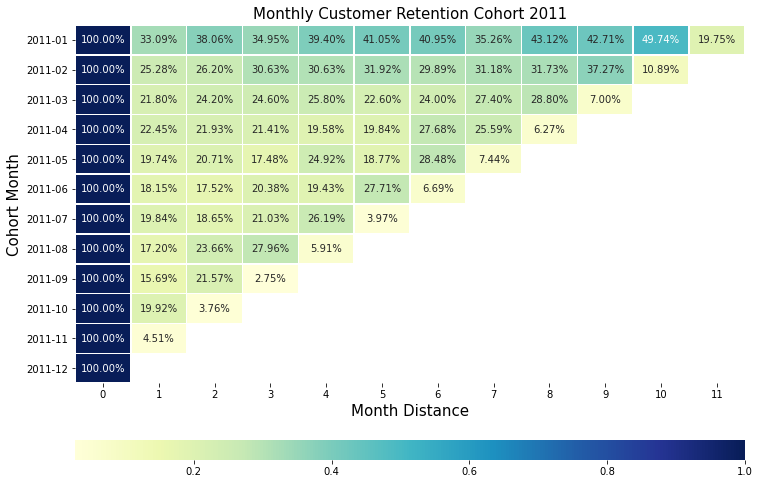

In [9]:
# Setup the space of plot
grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws,figsize=(12,8))

# Create heatmap 
ax = sns.heatmap(retention_in_percentage, 
                 ax=ax,
                 cbar_ax=cbar_ax,
                 annot=True,
                 fmt = '.2%', 
                 linewidths=.5,
                 cbar_kws={"orientation": "horizontal"},
                 cmap="YlGnBu")

# Set additional information
ax.set_title("Monthly Customer Retention Cohort 2011",fontsize=15)
ax.set_ylabel("Cohort Month",fontsize=15) 
ax.set_xlabel("Month Distance",fontsize=15)
plt.show()

## 4. Cohort Analysis : Data Visualization Lineplot

In [10]:
# We use this data
df_lineplot = df_cohort.copy()
df_lineplot.head()

,cohort_month,current_order_month,n_customers,period_number
0,2011-01,2011-01,967,0
1,2011-01,2011-02,320,1
2,2011-01,2011-03,368,2
3,2011-01,2011-04,338,3
4,2011-01,2011-05,381,4


### Data Preprocessing for Lineplot

We should transform our total users into percentage format.

For example:

| cohort_month | current_order_month | percentage_users | period_distance |
| -- | -- |-- | -- |
| 2021-01 | 2021-01 | 100 | 0 |
| 2021-01 | 2021-02 | 60 | 1 | 
| ....  | ... | ... | ... |
| 2021-01 | 2021-12 | 10  | 11|


**Interpretation**:

1. There are 100% who made first transaction in 2021-01 and made their transaction again in the same month (2021-01)
2. There are 60% users who made first transaction in 2021-01 and made their transaction again in 2021-02 
3. ...
4. There are 10% users who made first transaction in 2021-01 and made their transaction again in 2021-12

In [11]:
# Convert date format into string, since we will create another aggregation
df_lineplot["cohort_month"] = df_lineplot["cohort_month"].astype(str)
df_lineplot["current_order_month"] = df_lineplot["current_order_month"].astype(str)

# Then convert the total user into percentages
df_plot_state = df_lineplot.groupby(['cohort_month']).agg({'n_customers': 'max'})
df_plot = df_lineplot.set_index(["cohort_month"]).div(df_plot_state, level='cohort_month') * 100
df_plot = df_plot.reset_index()[["cohort_month","n_customers"]].rename(columns={"n_customers":"percentage_customers"})
df_plot.head()

# Add the piece of early version dataframe to complete the requirement
df_plot["current_order_month"] = df_lineplot["current_order_month"]
df_plot["period_number"] = df_lineplot["period_number"]
df_plot = df_plot[["cohort_month","current_order_month","percentage_customers","period_number"]]
df_plot.head()

,cohort_month,current_order_month,percentage_customers,period_number
0,2011-01,2011-01,100.000000,0
1,2011-01,2011-02,33.092037,1
2,2011-01,2011-03,38.055843,2
3,2011-01,2011-04,34.953464,3
4,2011-01,2011-05,39.400207,4


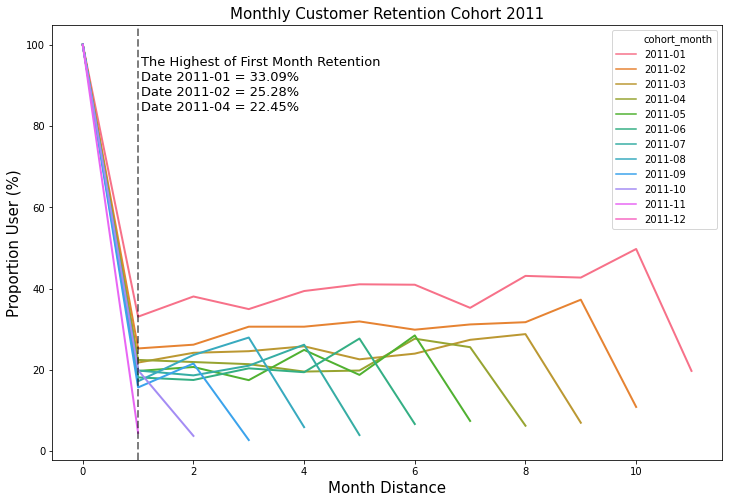

In [12]:
# Build the plot using lineplot
plt.figure(figsize=(12,8))
ax = sns.lineplot(x="period_number",
                  y="percentage_customers",
                  hue="cohort_month",
                  dashes=True,
                  linewidth=2,
                  data = df_plot,
                  palette="husl"
                  )

ax.set_title("Monthly Customer Retention Cohort 2011",fontsize=15)
ax.set_ylabel('Proportion User (%)',fontsize=15)    
ax.set_xlabel('Month Distance',fontsize=15)

# Optional: Create a line to inform the best 3 of first month retention
top_3 = df_plot[df_plot["period_number"]==1].sort_values("percentage_customers",ascending=False).iloc[:3]
top_3_name = top_3["cohort_month"].tolist()
top_3_value = [round(x,2) for x in top_3["percentage_customers"].tolist()]

# String information
text_plot = f"""
The Highest of First Month Retention
Date {top_3_name[0]} = {top_3_value[0]}%
Date {top_3_name[1]} = {top_3_value[1]}%
Date {top_3_name[2]} = {top_3_value[2]}%
"""
plt.axvline(x=1, linestyle='--', color="black", lw=2, alpha=.5)
plt.text(1.05, 80, text_plot,fontsize=13)
plt.show()